In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Check and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [2]:
# Federated learning hyperparameters
num_epochs, learning_rate = 5, 0.001
batch_sizes, communication_rounds = [64, 128], 100

In [3]:
# Define a deep learning model (CNN)
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Modify the architecture based on your requirements
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(512, 10)  # Assuming 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

In [4]:
# Dataset preparation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Assuming you have the FEMNIST dataset downloaded and split for each client
# Replace 'path_to_client_data' with the actual path to the client data
client_dataset = torchvision.datasets.FashionMNIST(root='path_to_client_data', train=True, download=True, transform=transform)

# Split the client dataset into train and validation sets
train_size = int(0.8 * len(client_dataset))
val_size = len(client_dataset) - train_size
client_train_set, client_val_set = random_split(client_dataset, [train_size, val_size])

# DataLoader for training and validation
train_loaders = [DataLoader(client_train_set, batch_size=batch_size, shuffle=True, num_workers=4) for batch_size in batch_sizes]
val_loader = DataLoader(client_val_set, batch_size=batch_sizes[0], shuffle=False, num_workers=4)

In [5]:
# Function to train the model for a given federated learning algorithm
def train_federated_learning(model, train_loader, algorithm_name):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    performance_metrics = {'accuracy': [], 'loss': []}

    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - {algorithm_name}'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print average loss at the end of each epoch
        average_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}] - {algorithm_name}, Loss: {average_loss:.4f}')

        # Evaluate on validation set
        accuracy = evaluate_model(model, val_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}] - {algorithm_name}, Validation Accuracy: {accuracy * 100:.2f}%')

        performance_metrics['accuracy'].append(accuracy)
        performance_metrics['loss'].append(average_loss)

    return performance_metrics

# Function to evaluate the model on the validation set
def evaluate_model(model, val_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [6]:
def train_federated_learningAdj(model, train_loader, algorithm_name, times):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Initialize the convolutional layer outside the loop
    in_channels = train_loader.dataset[0][0].shape[0]  # Number of input channels
    out_channels = max(1, in_channels - times) 
    conv_reduce_channels = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    
    performance_metrics = {'accuracy': [], 'loss': []}

    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - {algorithm_name}'):
            images, labels = images.to(device), labels.to(device)
            
            # Apply the convolutional layer to input images
            data = conv_reduce_channels(images)
            
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print average loss at the end of each epoch
        average_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}] - {algorithm_name}, Loss: {average_loss:.4f}')

        # Evaluate on validation set
        accuracy = evaluate_model(model, val_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}] - {algorithm_name}, Validation Accuracy: {accuracy * 100:.2f}%')

        performance_metrics['accuracy'].append(accuracy)
        performance_metrics['loss'].append(average_loss)

    return performance_metrics

# Define the evaluation function as provided
def evaluate_model(model, val_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [7]:
# Train & Evaluate FedMeta w/ UGA
fedmeta_uga_model = CNNModel().to(device)
fedmeta_uga_performance = train_federated_learning(fedmeta_uga_model, train_loaders[0], 'FedMeta w/ UGA')
fedmeta_uga_model1 = CNNModel().to(device)
fedmeta_uga_performance1= train_federated_learningAdj(fedmeta_uga_model1, train_loaders[0], 'FedMeta w/ UGA(100 Removed)', 100)
fedmeta_uga_model2 = CNNModel().to(device)
fedmeta_uga_performance2 = train_federated_learningAdj(fedmeta_uga_model2, train_loaders[0], 'FedMeta w/ UGA(200 Removed)', 200)
fedmeta_uga_model3 = CNNModel().to(device)
fedmeta_uga_performance3 = train_federated_learningAdj(fedmeta_uga_model3, train_loaders[0], 'FedMeta w/ UGA(400 Removed)', 400)
fedmeta_uga_model4 = CNNModel().to(device)
fedmeta_uga_performance4 = train_federated_learningAdj(fedmeta_uga_model4, train_loaders[0], 'FedMeta w/ UGA(800 Removed)', 800)

Epoch 1/5 - FedMeta w/ UGA: 100%|██████████| 750/750 [01:22<00:00,  9.11it/s]


Epoch [1/5] - FedMeta w/ UGA, Loss: 0.4326
Epoch [1/5] - FedMeta w/ UGA, Validation Accuracy: 88.96%


Epoch 2/5 - FedMeta w/ UGA: 100%|██████████| 750/750 [01:31<00:00,  8.17it/s]


Epoch [2/5] - FedMeta w/ UGA, Loss: 0.2750
Epoch [2/5] - FedMeta w/ UGA, Validation Accuracy: 89.69%


Epoch 3/5 - FedMeta w/ UGA: 100%|██████████| 750/750 [01:51<00:00,  6.73it/s]


Epoch [3/5] - FedMeta w/ UGA, Loss: 0.2239
Epoch [3/5] - FedMeta w/ UGA, Validation Accuracy: 91.81%


Epoch 4/5 - FedMeta w/ UGA: 100%|██████████| 750/750 [01:50<00:00,  6.81it/s]


Epoch [4/5] - FedMeta w/ UGA, Loss: 0.1872
Epoch [4/5] - FedMeta w/ UGA, Validation Accuracy: 92.06%


Epoch 5/5 - FedMeta w/ UGA: 100%|██████████| 750/750 [01:48<00:00,  6.89it/s]


Epoch [5/5] - FedMeta w/ UGA, Loss: 0.1567
Epoch [5/5] - FedMeta w/ UGA, Validation Accuracy: 92.12%


Epoch 1/5 - FedMeta w/ UGA(100 Removed): 100%|██████████| 750/750 [02:18<00:00,  5.43it/s]


Epoch [1/5] - FedMeta w/ UGA(100 Removed), Loss: 0.4433
Epoch [1/5] - FedMeta w/ UGA(100 Removed), Validation Accuracy: 22.18%


Epoch 2/5 - FedMeta w/ UGA(100 Removed): 100%|██████████| 750/750 [02:36<00:00,  4.80it/s]


Epoch [2/5] - FedMeta w/ UGA(100 Removed), Loss: 0.2758
Epoch [2/5] - FedMeta w/ UGA(100 Removed), Validation Accuracy: 22.22%


Epoch 3/5 - FedMeta w/ UGA(100 Removed): 100%|██████████| 750/750 [02:34<00:00,  4.85it/s]


Epoch [3/5] - FedMeta w/ UGA(100 Removed), Loss: 0.2265
Epoch [3/5] - FedMeta w/ UGA(100 Removed), Validation Accuracy: 19.74%


Epoch 4/5 - FedMeta w/ UGA(100 Removed): 100%|██████████| 750/750 [02:40<00:00,  4.66it/s]


Epoch [4/5] - FedMeta w/ UGA(100 Removed), Loss: 0.1903
Epoch [4/5] - FedMeta w/ UGA(100 Removed), Validation Accuracy: 25.26%


Epoch 5/5 - FedMeta w/ UGA(100 Removed): 100%|██████████| 750/750 [02:40<00:00,  4.67it/s]


Epoch [5/5] - FedMeta w/ UGA(100 Removed), Loss: 0.1621
Epoch [5/5] - FedMeta w/ UGA(100 Removed), Validation Accuracy: 14.65%


Epoch 1/5 - FedMeta w/ UGA(200 Removed): 100%|██████████| 750/750 [02:01<00:00,  6.18it/s]


Epoch [1/5] - FedMeta w/ UGA(200 Removed), Loss: 0.4474
Epoch [1/5] - FedMeta w/ UGA(200 Removed), Validation Accuracy: 18.76%


Epoch 2/5 - FedMeta w/ UGA(200 Removed): 100%|██████████| 750/750 [02:44<00:00,  4.56it/s]


Epoch [2/5] - FedMeta w/ UGA(200 Removed), Loss: 0.2892
Epoch [2/5] - FedMeta w/ UGA(200 Removed), Validation Accuracy: 21.35%


Epoch 3/5 - FedMeta w/ UGA(200 Removed): 100%|██████████| 750/750 [02:15<00:00,  5.53it/s]


Epoch [3/5] - FedMeta w/ UGA(200 Removed), Loss: 0.2384
Epoch [3/5] - FedMeta w/ UGA(200 Removed), Validation Accuracy: 18.93%


Epoch 4/5 - FedMeta w/ UGA(200 Removed):  14%|█▍        | 106/750 [00:10<01:03, 10.07it/s]


KeyboardInterrupt: 

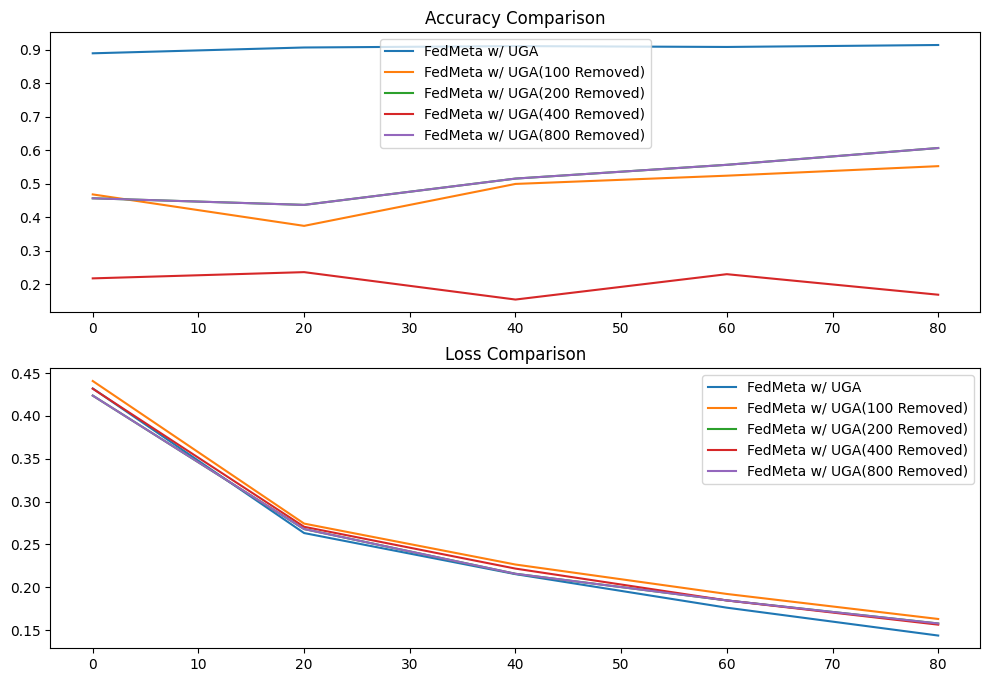

In [ ]:
# Create comparison plots for FEMNIST
plt.figure(figsize=(12, 8))

# Test accuracy comparison
plt.subplot(2, 1, 1)
plt.title("Accuracy Comparison")
sns.lineplot(x=range(0, communication_rounds, 20), y=fedmeta_uga_performance['accuracy'], label='FedMeta w/ UGA')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedmeta_uga_performance1['accuracy'], label='FedMeta w/ UGA(100 Removed)')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedmeta_uga_performance2['accuracy'], label='FedMeta w/ UGA(200 Removed)')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedmeta_uga_performance3['accuracy'], label='FedMeta w/ UGA(400 Removed)')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedmeta_uga_performance4['accuracy'], label='FedMeta w/ UGA(800 Removed)')

# Loss comparison
plt.subplot(2, 1, 2)
plt.title("Loss Comparison")
sns.lineplot(x=range(0, communication_rounds, 20), y=fedmeta_uga_performance['loss'], label='FedMeta w/ UGA')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedmeta_uga_performance1['loss'], label='FedMeta w/ UGA(100 Removed)')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedmeta_uga_performance2['loss'], label='FedMeta w/ UGA(200 Removed)')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedmeta_uga_performance3['loss'], label='FedMeta w/ UGA(400 Removed)')
sns.lineplot(x=range(0, communication_rounds, 20), y=fedmeta_uga_performance4['loss'], label='FedMeta w/ UGA(800 Removed)')

plt.show()